# <center> Convolutional Neural Network

### Convolutional Layers: [128,128] ; Dense Layers [128,128]
### Activation function = ELU; Weight initializer = He

CNN is trained on raw data

## <font color = 'blue'> Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_test              -> defaultdict(<class 'list'>, {0: array([[[  2.23553
X_train             -> array([[[ -1.49427662e-02,  -5.38582681e-03,   3.2
snrs                -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_test              -> defaultdict(<class 'list'>, {0: array([1, 4, 1, ..
y_train             -> array([1, 5, 7, ..., 4, 3, 3])


In [2]:
print("Training data: ", X_train.shape, "and labels: ", y_train.shape)
print()
print("Test data:")
print("Total", len(X_test), X_test[18].shape, "arrays for SNR values:")
print(sorted(X_test.keys()))

Training data:  (80000, 2, 128) and labels:  (80000,)

Test data:
Total 20 (4000, 2, 128) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## <font color = 'blue'> Standardize the features

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
_X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
_X_train = sc.fit_transform(_X_train)

X_train = np.reshape(_X_train, X_train.shape)
print("Training set", X_train.shape)

_X_test = defaultdict(list)
for snr in snrs:
    _X_test[snr] = np.reshape(X_test[snr], [X_test[snr].shape[0], X_test[snr].shape[1]*X_test[snr].shape[2]])
    _X_test[snr] = sc.transform(_X_test[snr])
    X_test[snr] = np.reshape(_X_test[snr], X_test[snr].shape)
    
print("Test set corresponding to one snr value", X_test[18].shape)

Training set (80000, 2, 128)
Test set corresponding to one snr value (4000, 2, 128)


## <font color = 'blue'> Design and train the CNN

In [4]:
height = 2
width = 128
channels = 1
n_features = height * width

feature_map1 = 128
ksize_conv1 = 2
stride_conv1 = 1

feature_map2 = 128
ksize_conv2 = 2
stride_conv2 = 1

pool_layer_maps = 128

n_fully_conn1 = 128
n_fully_conn2 = 128

n_classes = 8
  
X = tf.placeholder(tf.float32, shape=[None, height, width])
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
labels = tf.placeholder(tf.int32, shape=[None])

weight_init = tf.contrib.layers.variance_scaling_initializer()
activation_func = tf.nn.elu

# ------------------ Convolutional layers ----------------------------

def convolutional_layer(X, filter_, ksize, kernel_init, strides, padding):
    convolutional_layer = tf.layers.conv2d(X, filters = filter_, kernel_initializer = kernel_init,
                                           kernel_size = ksize, strides = strides,
                                          padding = padding, activation = activation_func)
    return convolutional_layer

conv_layer1 = convolutional_layer(X_reshaped, feature_map1, ksize_conv1, weight_init, stride_conv1, padding = "SAME")

conv_layer2 = convolutional_layer(conv_layer1, feature_map2, ksize_conv2, weight_init, stride_conv2, padding = "SAME")

# ----------------- Pooling layers -------------------------------------

def pooling_layer(convlayer, ksize, strides, padding, pool_maps):
    pool = tf.nn.max_pool(convlayer, ksize, strides, padding)
    dim1, dim2 = int(pool.get_shape()[1]), int(pool.get_shape()[2])
    pool_flat = tf.reshape(pool, shape = [-1, pool_maps * dim1 * dim2])
    return pool_flat

pool_layer_flat = pooling_layer(conv_layer2, [1,2,2,1], [1,2,2,1], "VALID", pool_layer_maps)

# ----------------- Fully connected layers -------------------

def dense_layer(input_layer, n_neurons, kernel_init, activation):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init)
    return fully_conn
        
dense_layer1 = dense_layer(pool_layer_flat, n_fully_conn1, weight_init, activation_func)

dense_layer2 = dense_layer(dense_layer1, n_fully_conn2, weight_init, activation_func)

# ----------------- Output softmax layer ---------------------------

logits = tf.layers.dense(dense_layer2, n_classes)
softmax_activations = tf.nn.softmax(logits)

# ----------------- Specify performance measure -------------------------------

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
train_operation = optimizer.minimize(loss)

correct_predictions = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# ---------------- Execution phase -------------------------------------------
    
n_epochs = 10
batch_size = 1024
n_train = X_train.shape[0]
n_iter = n_train//batch_size

acc_test = defaultdict(list)

path = "./CNN_elu_he"  
saver = tf.train.Saver()

start = time()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size)    
            X_batch, y_batch = X_train[rand_indices], y_train[rand_indices]
            sess.run(train_operation, feed_dict={X: X_batch, labels: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, labels: y_batch})
        print("Epoch {} training accuracy : {}".format(epoch, acc_train))
        save_path = saver.save(sess, path)
        saver.restore(sess, path)
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_test[snr], labels: y_test[snr]})

print("Training took %f minutes"%(float(time() - start)/60.0))

Epoch 0 training accuracy : 0.2568359375
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 1 training accuracy : 0.421875
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 2 training accuracy : 0.4736328125
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 3 training accuracy : 0.5205078125
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 4 training accuracy : 0.509765625
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 5 training accuracy : 0.5380859375
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 6 training accuracy : 0.591796875
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 7 training accuracy : 0.630859375
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 8 training accuracy : 0.6552734375
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Epoch 9 training accuracy : 0.6845703125
INFO:tensorflow:Restoring parameters from ./CNN_elu_he
INFO:tensorflow:Restoring parameters from ./CNN

## <font color = 'blue'> Test the classifier

In [5]:
for snr in snrs:
    print("CNN's test accuracy on {}dB SNR samples = {}".format(snr,acc_test[snr]))  

CNN's test accuracy on -20dB SNR samples = 0.132750004529953
CNN's test accuracy on -18dB SNR samples = 0.12399999797344208
CNN's test accuracy on -16dB SNR samples = 0.13474999368190765
CNN's test accuracy on -14dB SNR samples = 0.15850000083446503
CNN's test accuracy on -12dB SNR samples = 0.17299999296665192
CNN's test accuracy on -10dB SNR samples = 0.20149999856948853
CNN's test accuracy on -8dB SNR samples = 0.2757500112056732
CNN's test accuracy on -6dB SNR samples = 0.3345000147819519
CNN's test accuracy on -4dB SNR samples = 0.4502499997615814
CNN's test accuracy on -2dB SNR samples = 0.5874999761581421
CNN's test accuracy on 0dB SNR samples = 0.6852499842643738
CNN's test accuracy on 2dB SNR samples = 0.7567499876022339
CNN's test accuracy on 4dB SNR samples = 0.7602499723434448
CNN's test accuracy on 6dB SNR samples = 0.7667499780654907
CNN's test accuracy on 8dB SNR samples = 0.765500009059906
CNN's test accuracy on 10dB SNR samples = 0.7832499742507935
CNN's test accuracy 

## <font color = 'blue'> Visualize classifier's performance on test set

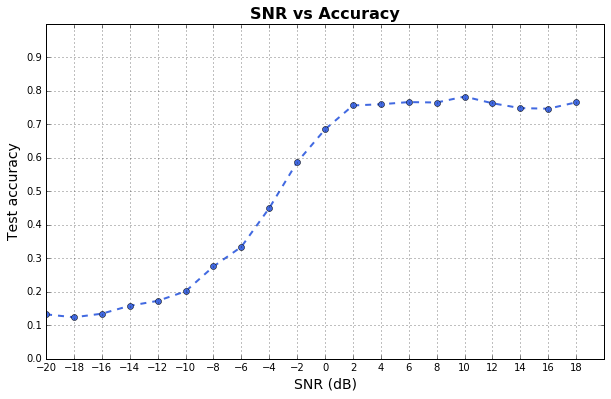

In [6]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./CNN_elu_he
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.66  0.00   0.01  0.01  0.00   0.07   0.05  0.20
BPSK   0.00  0.97   0.00  0.00  0.01   0.00   0.00  0.01
CPFSK  0.01  0.00   0.98  0.00  0.00   0.00   0.00  0.01
GFSK   0.01  0.00   0.00  0.99  0.00   0.00   0.00  0.00
PAM4   0.00  0.04   0.00  0.00  0.95   0.00   0.00  0.00
QAM16  0.11  0.00   0.00  0.00  0.00   0.41   0.40  0.07
QAM64  0.08  0.00   0.00  0.00  0.00   0.42   0.45  0.05
QPSK   0.15  0.01   0.00  0.01  0.00   0.03   0.02  0.77


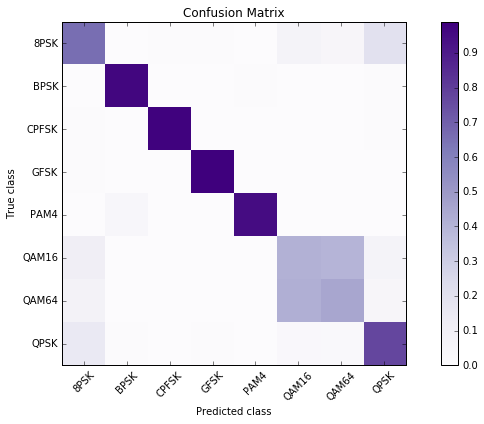

In [7]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_test[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()